# Modelling Exploration Notebook V1

This Notebook focuses on comparing different forecast models provided by GluonTS. <br /> 
Experiments were run using Python 3.9 and PyTorch 1.13. <br /> 
Compared were:
- DeepAR (Salinas et al. 2020): [torch impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py)
- DeepState (Rangapuram et al. 2018): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py)
- MQ-CNN (Wen et al. 2017): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py)

In [3]:
# Required Packages
# !pip install -r ./src/requirements.txt

In [57]:
# Imports experiment script
from src.forecast_experiment import run_experiment
from src.forecast_util import plot_forecast
# Import packages
from datetime import timedelta
import json

## Experiment Overview

### Define Configuration Store

In [58]:
from sqlalchemy import create_engine, Column, Integer, Float, String, PickleType,  select
# from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [59]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    version = Column('version', Integer)
    data_config = Column('data_config', PickleType)
    model_config = Column('model_config', PickleType)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_10', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

In [60]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///./config/forecast_config_v2.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Explore Experiments

The model name follows this naming convention: {framework}_{model_name}. <br />
- The framework specifies the Machine Learning Framework used to implement the model (mxnet, torch, tensorflow)
- The model_name specifies the Algorithm used (e.g. DeepAR). 

The version field is used to track the stage of experiments as defined below. This means general progression of modelling insights as well as updated data sources.

- version 1: first exploration
    - "../data_engineering/financial_ts/indices.csv",
    - "../data_engineering/financial_ts/ww_gdp.csv",
    - "../data_engineering/timeseries_data/ts_dgelt_events.csv"
- version 2: specific exploration
    - "../data_engineering/financial_ts/indices.csv",
    - "../data_engineering/financial_ts/ww_gdp.csv",
    - "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv"

In [31]:
# Query experiment Table and print results:
q1 = select(Forecast_Experiment).order_by(Forecast_Experiment.avg_wQL)
q1_result = session.execute(q1) 

for s in q1_result.scalars():
    print(f"""{s.model}: {s.version} 
        - model_config: {str(s.model_config)[1:-1].replace("'","")}:
        - MAPE: {s.MAPE},
        - avg_wQL: {s.avg_wQL},
        """
    )

torch_deepar: 1 
        - model_config: epochs: 1000, prediction_length: 20, num_layers: 8, hidden_size: 64, context_length: 56, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.04679007808624215,
        - avg_wQL: 0.03054266891615841,
        
torch_deepar: 1 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 60, context_length: 200, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.04398518378674155,
        - avg_wQL: 0.03393084310078053,
        
torch_deepar: 1 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 40, context_length: 200, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.04867304946676913,
        - avg_wQL: 0.035919825705461,
        
torch_deepar: 1 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 40, context_length: 100, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.05248577369460426,
        - avg_wQL: 0.04011049213329933,
        
torch_deep

### Migrate Experiments

The Experiments from the modelling_experimentation_v1 notebook were stored in two different Tables. <br />
I exported them to a json file and used the below code to read the file and store previous experiments in the new database with dynamic config attributes.

In [30]:
import json
 
# Opening JSON file
with open('data_v2.json') as json_file:
    data = json.load(json_file)

In [36]:
for e in data:
    experiment_config = Forecast_Experiment(
        model = e['name'],
        version = 1,
        data_config = {
            'target':e['target'],
            'past_rts_col':e['past_rts_col'],
            'windows':1,
        },
        model_config = {
            'epochs':e['epochs'],
            'prediction_length':e['prediction_length'],
            'num_layers':e['num_layers'],
            'hidden_size':e['hidden_size'],
            # 'context_length':e['context_length'],
            'lr':e['lr'],
            'weight_decay':e['weight_decay'],
        },
        MASE = e['MASE'],
        MAPE = e['MAPE'],
        RMSE = e['RMSE'],
        wQL_10 = e['wQL_10'],
        wQL_50 = e['wQL_50'],
        wQL_90 = e['wQL_90'],
        avg_wQL = e['avg_wQL']
    )
    session.add(experiment_config)
    session.commit()

## DeepAR ([torch](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py))

DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an autoregressive recurrent neural network model on a large number of related time series.

In [61]:
from gluonts.torch import DeepAREstimator

In [75]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv"
]
target_col = 'ts_S&P' # switch to ts_S&P
with open('./config/past_rts_cols_v2.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_2']
windows = 8
 
# epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 60, context_length: 200, lr: 0.001, weight_decay: 1e-08

# Estimator specs
version = 2
prediction_length=52
max_epochs = 100
num_layers=3
hidden_size=20
context_length = 200 
weight_decay = 1e-15
lr = 0.001
offset = -(prediction_length*windows)

# Trainer specs
accelerator = "gpu"
devices = "auto"

In [76]:
# Define estimator
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    num_layers=num_layers,  
    hidden_size=hidden_size, 
    weight_decay=weight_decay,
    context_length=context_length,
    lr = lr,
    freq="W",
    trainer_kwargs={
        "max_epochs": max_epochs, 
        "accelerator":accelerator, 
        "devices":devices,
    }
)

In [78]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    offset = offset,
    past_rts_col=past_rts_col,
    estimator=deepar_estimator,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 10.5 K | ?        | [1, 100, 52]
----------------------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Epoch 0: : 50it [00:08,  5.72it/s, v_num=113, train_loss=6.200]

Epoch 0, global step 50: 'train_loss' reached 6.20051 (best 6.20051), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:08,  5.74it/s, v_num=113, train_loss=5.050]

Epoch 1, global step 100: 'train_loss' reached 5.05115 (best 5.05115), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:08,  5.68it/s, v_num=113, train_loss=4.450]

Epoch 2, global step 150: 'train_loss' reached 4.44727 (best 4.44727), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:08,  5.91it/s, v_num=113, train_loss=4.090]

Epoch 3, global step 200: 'train_loss' reached 4.08702 (best 4.08702), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: : 50it [00:08,  5.94it/s, v_num=113, train_loss=3.870]

Epoch 4, global step 250: 'train_loss' reached 3.86956 (best 3.86956), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: : 50it [00:08,  5.91it/s, v_num=113, train_loss=3.920]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: : 50it [00:08,  5.93it/s, v_num=113, train_loss=3.890]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: : 50it [00:08,  5.97it/s, v_num=113, train_loss=3.810]

Epoch 7, global step 400: 'train_loss' reached 3.80532 (best 3.80532), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: : 50it [00:08,  5.90it/s, v_num=113, train_loss=3.710]

Epoch 8, global step 450: 'train_loss' reached 3.71079 (best 3.71079), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: : 50it [00:08,  5.98it/s, v_num=113, train_loss=3.780]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: : 50it [00:08,  5.86it/s, v_num=113, train_loss=3.710]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: : 50it [00:08,  5.87it/s, v_num=113, train_loss=3.600]

Epoch 11, global step 600: 'train_loss' reached 3.60234 (best 3.60234), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: : 50it [00:08,  5.99it/s, v_num=113, train_loss=3.790]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: : 50it [00:08,  6.09it/s, v_num=113, train_loss=3.740]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: : 50it [00:08,  6.06it/s, v_num=113, train_loss=3.740]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: : 50it [00:08,  6.22it/s, v_num=113, train_loss=3.720]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: : 50it [00:07,  6.38it/s, v_num=113, train_loss=3.700]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: : 50it [00:08,  5.87it/s, v_num=113, train_loss=3.500]

Epoch 17, global step 900: 'train_loss' reached 3.50500 (best 3.50500), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: : 50it [00:08,  5.85it/s, v_num=113, train_loss=3.580]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: : 50it [00:08,  6.10it/s, v_num=113, train_loss=3.610]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: : 50it [00:08,  6.03it/s, v_num=113, train_loss=3.660]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: : 50it [00:08,  5.89it/s, v_num=113, train_loss=3.630]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: : 50it [00:08,  5.77it/s, v_num=113, train_loss=3.590]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: : 50it [00:08,  5.97it/s, v_num=113, train_loss=3.560]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: : 50it [00:08,  6.12it/s, v_num=113, train_loss=3.580]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: : 50it [00:08,  5.87it/s, v_num=113, train_loss=3.550]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: : 50it [00:08,  5.98it/s, v_num=113, train_loss=3.550]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: : 50it [00:08,  5.87it/s, v_num=113, train_loss=3.430]

Epoch 27, global step 1400: 'train_loss' reached 3.43136 (best 3.43136), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: : 50it [00:08,  6.02it/s, v_num=113, train_loss=3.560]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: : 50it [00:08,  5.77it/s, v_num=113, train_loss=3.490]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: : 50it [00:08,  6.00it/s, v_num=113, train_loss=3.470]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: : 50it [00:08,  5.99it/s, v_num=113, train_loss=3.560]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: : 50it [00:07,  6.27it/s, v_num=113, train_loss=3.490]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: : 50it [00:08,  5.97it/s, v_num=113, train_loss=3.360]

Epoch 33, global step 1700: 'train_loss' reached 3.35653 (best 3.35653), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: : 50it [00:08,  5.86it/s, v_num=113, train_loss=3.370]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: : 50it [00:08,  6.06it/s, v_num=113, train_loss=3.510]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: : 50it [00:08,  5.66it/s, v_num=113, train_loss=3.340]

Epoch 36, global step 1850: 'train_loss' reached 3.33631 (best 3.33631), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=36-step=1850.ckpt' as top 1


Epoch 37: : 50it [00:08,  5.92it/s, v_num=113, train_loss=3.370]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: : 50it [00:08,  5.97it/s, v_num=113, train_loss=3.330]

Epoch 38, global step 1950: 'train_loss' reached 3.32935 (best 3.32935), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: : 50it [00:08,  5.95it/s, v_num=113, train_loss=3.320]

Epoch 39, global step 2000: 'train_loss' reached 3.31703 (best 3.31703), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: : 50it [00:08,  6.24it/s, v_num=113, train_loss=3.320]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: : 50it [00:08,  5.84it/s, v_num=113, train_loss=3.310]

Epoch 41, global step 2100: 'train_loss' reached 3.30518 (best 3.30518), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: : 50it [00:08,  5.91it/s, v_num=113, train_loss=3.290]

Epoch 42, global step 2150: 'train_loss' reached 3.29038 (best 3.29038), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: : 50it [00:08,  5.79it/s, v_num=113, train_loss=3.320]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: : 50it [00:08,  6.05it/s, v_num=113, train_loss=3.330]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: : 50it [00:08,  5.96it/s, v_num=113, train_loss=3.300]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: : 50it [00:08,  5.98it/s, v_num=113, train_loss=3.350]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: : 50it [00:08,  5.96it/s, v_num=113, train_loss=3.290]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: : 50it [00:08,  5.94it/s, v_num=113, train_loss=3.480]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: : 50it [00:08,  5.97it/s, v_num=113, train_loss=3.340]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: : 50it [00:08,  5.95it/s, v_num=113, train_loss=3.360]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: : 50it [00:08,  5.75it/s, v_num=113, train_loss=3.340]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: : 50it [00:08,  5.98it/s, v_num=113, train_loss=3.360]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: : 50it [00:08,  6.22it/s, v_num=113, train_loss=3.390]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: : 50it [00:08,  6.01it/s, v_num=113, train_loss=3.330]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: : 50it [00:08,  6.20it/s, v_num=113, train_loss=3.340]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: : 50it [00:08,  5.99it/s, v_num=113, train_loss=3.280]

Epoch 56, global step 2850: 'train_loss' reached 3.27969 (best 3.27969), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=56-step=2850.ckpt' as top 1


Epoch 57: : 50it [00:08,  6.02it/s, v_num=113, train_loss=3.310]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: : 50it [00:08,  5.87it/s, v_num=113, train_loss=3.340]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: : 50it [00:08,  6.04it/s, v_num=113, train_loss=3.200]

Epoch 59, global step 3000: 'train_loss' reached 3.20305 (best 3.20305), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=59-step=3000.ckpt' as top 1


Epoch 60: : 50it [00:08,  5.83it/s, v_num=113, train_loss=3.310]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: : 50it [00:08,  6.03it/s, v_num=113, train_loss=3.340]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: : 50it [00:08,  6.12it/s, v_num=113, train_loss=3.290]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: : 50it [00:08,  6.09it/s, v_num=113, train_loss=3.280]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: : 50it [00:08,  5.92it/s, v_num=113, train_loss=3.280]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: : 50it [00:08,  6.10it/s, v_num=113, train_loss=3.320]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: : 50it [00:08,  5.97it/s, v_num=113, train_loss=3.200]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: : 50it [00:08,  6.01it/s, v_num=113, train_loss=3.370]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: : 50it [00:08,  5.94it/s, v_num=113, train_loss=3.240]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: : 50it [00:08,  6.15it/s, v_num=113, train_loss=3.220]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: : 50it [00:08,  6.10it/s, v_num=113, train_loss=3.210]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: : 50it [00:08,  5.90it/s, v_num=113, train_loss=3.200]

Epoch 71, global step 3600: 'train_loss' reached 3.19912 (best 3.19912), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=71-step=3600.ckpt' as top 1


Epoch 72: : 50it [00:08,  5.81it/s, v_num=113, train_loss=3.220]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: : 50it [00:08,  5.87it/s, v_num=113, train_loss=3.170]

Epoch 73, global step 3700: 'train_loss' reached 3.17364 (best 3.17364), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=73-step=3700.ckpt' as top 1


Epoch 74: : 50it [00:09,  5.38it/s, v_num=113, train_loss=3.230]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: : 50it [00:08,  5.63it/s, v_num=113, train_loss=3.180]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: : 50it [00:08,  5.75it/s, v_num=113, train_loss=3.220]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: : 50it [00:08,  5.79it/s, v_num=113, train_loss=3.170]

Epoch 77, global step 3900: 'train_loss' reached 3.16770 (best 3.16770), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=77-step=3900.ckpt' as top 1


Epoch 78: : 50it [00:08,  5.80it/s, v_num=113, train_loss=3.250]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: : 50it [00:08,  5.68it/s, v_num=113, train_loss=3.130]

Epoch 79, global step 4000: 'train_loss' reached 3.12897 (best 3.12897), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_113/checkpoints/epoch=79-step=4000.ckpt' as top 1


Epoch 80: : 50it [00:08,  5.58it/s, v_num=113, train_loss=3.240]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: : 50it [00:08,  5.72it/s, v_num=113, train_loss=3.250]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: : 50it [00:08,  5.66it/s, v_num=113, train_loss=3.210]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: : 50it [00:08,  5.63it/s, v_num=113, train_loss=3.240]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: : 50it [00:08,  5.57it/s, v_num=113, train_loss=3.210]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: : 50it [00:08,  5.61it/s, v_num=113, train_loss=3.320]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: : 50it [00:08,  5.77it/s, v_num=113, train_loss=3.220]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: : 50it [00:09,  5.54it/s, v_num=113, train_loss=3.200]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: : 50it [00:09,  5.29it/s, v_num=113, train_loss=3.160]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: : 50it [00:09,  5.49it/s, v_num=113, train_loss=3.200]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: : 50it [00:09,  5.54it/s, v_num=113, train_loss=3.210]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: : 50it [00:08,  6.14it/s, v_num=113, train_loss=3.140]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: : 50it [00:08,  6.08it/s, v_num=113, train_loss=3.170]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: : 50it [00:09,  5.55it/s, v_num=113, train_loss=3.160]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: : 50it [00:08,  5.82it/s, v_num=113, train_loss=3.190]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: : 50it [00:08,  5.66it/s, v_num=113, train_loss=3.170]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: : 50it [00:08,  5.93it/s, v_num=113, train_loss=3.210]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: : 50it [00:08,  5.82it/s, v_num=113, train_loss=3.230]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: : 50it [00:08,  5.56it/s, v_num=113, train_loss=3.200]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: : 50it [00:08,  5.67it/s, v_num=113, train_loss=3.220]

Epoch 99, global step 5000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: : 50it [00:08,  5.63it/s, v_num=113, train_loss=3.220]



Running evaluation: 1it [00:00,  7.13it/s]


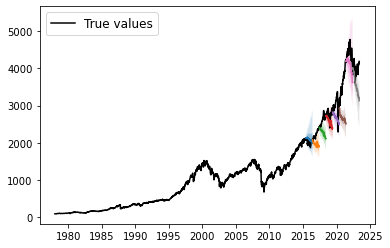

In [79]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    path="./8year_test.svg",
)

In [80]:
import pickle

with open('8year_test_tss.pkl', 'wb') as outp:
    pickle.dump(tss, outp, pickle.HIGHEST_PROTOCOL)

with open('8year_test_forecasts.pkl', 'wb') as outp:
    pickle.dump(forecasts, outp, pickle.HIGHEST_PROTOCOL)

In [81]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'torch_deepar_8year_v6',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'context_length':context_length,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

## DeepState ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py))

DeepState is a novel approach to probabilistic time series forecasting that combines state space models with deep learning. By parametrizing a per-time-series linear state space model with a jointly-learned recurrent neural network, our method retains desired properties of state space models such as data efficiency and interpretability, while making use of the ability to learn complex patterns from raw data offered by deep learning approaches.

In [9]:
from gluonts.mx import DeepStateEstimator
from gluonts.mx import Trainer

In [10]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
num_layers=2
hidden_size=20

# Trainer specs
max_epochs = 100
lr = 1e-1
weight_decay = 1e-4

In [11]:
# Define estimator
deepstate_estimator = DeepStateEstimator(
    prediction_length=prediction_length,
    num_layers=num_layers, 
    num_cells=hidden_size, 
    use_feat_static_cat=False,
    cardinality=[],
    trainer = Trainer(
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    freq="W",
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=deepstate_estimator,
)

100%|██████████| 50/50 [01:33<00:00,  1.87s/it, epoch=100/100, avg_epoch_loss=4.13]
Running evaluation: 1it [00:00,  3.58it/s]


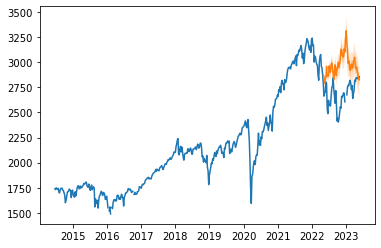

In [13]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./plot.svg",
)

In [14]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_deepstate',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 

## MQ-CNN ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py))

MQ-CNN is a general probabilistic multi-step time series regression model. It exploits the expressiveness and temporal nature of Sequence-to-Sequence Neural Networks (e.g. recurrent and convolutional structures), the nonparametric nature of Quantile Regression and the efficiency of Direct Multi-Horizon Forecasting.


In [6]:
from gluonts.mx import MQCNNEstimator
from gluonts.mx import Trainer
import mxnet as mx

In [7]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
decoder_mlp_dim_seq=[30]
channels_seq=[30,30,30]
use_past_feat_dynamic_real=True
context_length=50

# Trainer specs
max_epochs = 200
lr = 1e-1
weight_decay = 1e-4
ctx = mx.cpu() # mx.gpu()

In [8]:
mqcnn_estimator = MQCNNEstimator(
    prediction_length=prediction_length,
    channels_seq=channels_seq,  
    use_past_feat_dynamic_real=use_past_feat_dynamic_real,
    decoder_mlp_dim_seq=decoder_mlp_dim_seq, 
    context_length=context_length,
    freq="W",
    trainer=Trainer(
        ctx=ctx,
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=mqcnn_estimator,
)

100%|██████████| 50/50 [00:29<00:00,  1.70it/s, epoch=200/200, avg_epoch_loss=1.35]
Running evaluation: 1it [00:00,  6.59it/s]


In [4]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./plot.svg",
)

NameError: name 'tss' is not defined

In [ ]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_cnnqr',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'channels_seq':channels_seq,
        'decoder_mlp_dim_seq':decoder_mlp_dim_seq,
        'use_past_feat_dynamic_real':use_past_feat_dynamic_real,
        'context_length':context_length,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 
print("done")